In [1]:
%pylab inline
import convis

Populating the interactive namespace from numpy and matplotlib


Using gpu device 0: Quadro K620 (CNMeM is disabled, cuDNN not available)


/mnt/BigData/Environments/default/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  from ipykernel import kernelapp as app


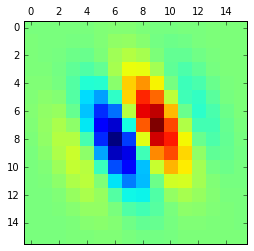

In [2]:
the_input = (convis.samples.sparse_input(2000,20,20,p=0.01) 
            - convis.samples.sparse_input(2000,20,20,p=0.01))

kernel = convis.samples.gabor_kernel()
matshow(kernel)

In [3]:
m = convis.M()
K = convis.simple_filters.ConvolutionFilter2d({'kernel':kernel},name="K")
m.add_output(K)
def compute_goal(the_input):
    o = m.run(the_input)
    return o[0]
o_goal = compute_goal(the_input)
figure()
convis.describe(o_goal)

{}

/mnt/BigData/Environments/default/lib/python2.7/site-packages/IPython/kernel/__main__.py:22: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


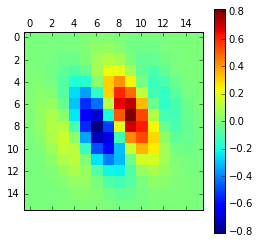

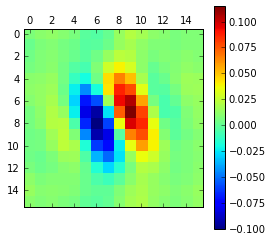

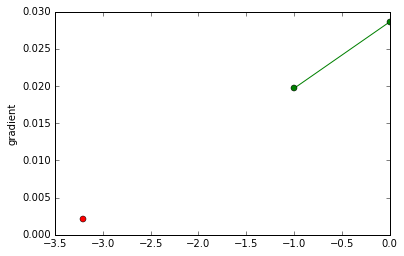

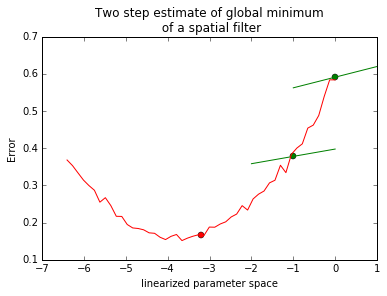

In [13]:
import theano
import theano.tensor as T

ground_truth_kernel = m.variables.K.kernel.get_value()

new_kernel = 0.1*np.ones((16,16))
m2 = convis.M()
m2.shape = the_input.shape
K = convis.simple_filters.ConvolutionFilter2d({'kernel':new_kernel},name="K")
m2.add_output(K)
goal_input = convis.as_input(T.dtensor3(),name='goal')
error_term = (K.graph-goal_input)**2
grad_term = theano.grad(T.mean(error_term),K.variables.kernel)
m2.outputs.append(error_term)
m2.outputs.append(grad_term)
m2.outputs.append(K.variables.kernel - grad_term)
m2.create_function(updates = {K.variables.kernel:K.variables.kernel - 15.0*grad_term}, additional_inputs=[goal_input])

def do_run():
    global the_input
    the_input = (convis.samples.sparse_input(200,20,20,p=0.01) 
            - convis.samples.sparse_input(200,20,20,p=0.01))
    global o_goal
    o_goal = compute_goal(the_input)
    global noise_level
    o_fit = m2.run(the_input,additional_inputs=[o_goal+noise_level*rand(*o_goal.shape)])
    return o_fit

colors = cm.gnuplot2(np.linspace(0.1,0.9,50))
error = []
kernel_mean = []
estimated_kernels = []
epsilon = 0.01
noise_level = 0.01
step = 1.0

m2.variables.K.kernel.set_value(new_kernel)
o_fit = do_run()
# first sample of gradient
e1 = o_fit[1]
g1 = o_fit[2]

m2.variables.K.kernel.set_value(new_kernel - step* g1)
o_fit = do_run()
# second sample of gradient
e2 = o_fit[1]
g2 = o_fit[2]

"""
We estimated two points on the linear trajectory:

(0,g1) at the initial (homogeneous) kernel (`new_kernel`)

(-step,g2) at the initial kernel minus step * the first gradient

The magnitudes of the two gradients form a line that intersects 
the x-axis where the minimum of the error function will be.
"""

incline = (np.mean(g1)-np.mean(g2))/(0.0+step)
minimum = -np.mean(g1)/incline
minimum_kernel = new_kernel + minimum*g1

m2.variables.K.kernel.set_value(minimum_kernel)
o_fit = do_run()
e3 = o_fit[1]
g3 = o_fit[2]


matshow(ground_truth_kernel)
colorbar()

matshow(minimum_kernel)
colorbar()

figure()
plot([0,-step],[np.mean(g1),np.mean(g2)],'go-')
plot(minimum,np.mean(g3),'ro')
ylabel('gradient')

figure()
plot(0,np.mean(e1),'go')
plot([1.0,-1.0],[np.mean(e1)+np.mean(g1),np.mean(e1)-np.mean(g1)],'g-')
plot(-step,np.mean(e2),'go')
plot([-step+1.0,-step-1.0],[np.mean(e2)+np.mean(g2),np.mean(e2)-np.mean(g2)],'g-')
plot(minimum,np.mean(e3),'ro')
ylabel('Error')


e4 = []
for r in np.linspace(2.0*minimum,0.0,50):
    m2.variables.K.kernel.set_value(new_kernel + r*g1)
    o_fit = do_run()
    e4.append(np.mean(o_fit[1]))
plot(np.linspace(2.0*minimum,0.0,50),e4,'r-')
title('Two step estimate of global minimum\n of a spatial filter')
xlabel('linearized parameter space')